In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

import datasets, transforms, GusarevModel, pytorch_msssim

# Flags:
flag_savePictures = False

# Paths
PATH_SAVE_NETWORK_INTERMEDIATE = "./trained_network.tar"


# Data
_batch_size = 10
image_spatial_size = (440,440)

switch = "external_POLYU" #"internal"##

if switch == "internal":
    directory_source = "D:/data/JSRT/augmented/test/source/"
    directory_boneless = "D:/data/JSRT/augmented/test/target/"
    keys_images = ["source", "boneless"]
    ds = datasets.JSRT_CXR(directory_source, directory_boneless, 
                           transform=tvtransforms.Compose([
                                 transforms.RescalingNormalisation(keys_images,(0,1)),
                                 transforms.RandomIntensityComplement(keys_images, probability=0.5),
                                 transforms.Rescale(image_spatial_size, keys_images, None),
                                 transforms.ToTensor(keys_images),
                                 ]))
elif switch == "external_POLYU":
    externalTest_directory = "D:/data/POLYU_COVID19_CXR_CT_Cohort1/cxr/CXR_PNG"
    keys_images = ["source"]
    ds = datasets.POLYU_COVID19_CXR_CT_Cohort1(externalTest_directory,
                                 transform=tvtransforms.Compose([
                                 transforms.RescalingNormalisation(keys_images,(0,1)),
                                 transforms.RandomIntensityComplement(keys_images, probability=0.5),
                                 transforms.Rescale(image_spatial_size, keys_images, None),
                                 transforms.ToTensor(keys_images),
                                 ]))
print(len(ds))
dl = DataLoader(ds, _batch_size, shuffle=True, num_workers=0)


# Select test 
sample = next(iter(dl))
print(sample["source"].shape)


1021
torch.Size([10, 1, 440, 440])


In [2]:
# Network
input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
net = GusarevModel.MultilayerCNN(input_array_size)
#net = nn.DataParallel(net, list(range(ngpu)))
if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
    print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
    checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE, map_location='cpu')
    start_epoch = checkpoint['epoch_next']
    reals_shown_now = checkpoint['reals_shown']
    net.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                        start_epoch, reals_shown_now))
else:
    print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
    raise RuntimeError("No checkpoint found at specified path.")

net.eval()
out = net(sample["source"])
out = out.detach()

Using 6-Layer MultiCNN Model.
=> loading checkpoint './trained_network.tar'
=> loaded checkpoint './trained_network.tar' (epoch 150, reals shown 598500)


.


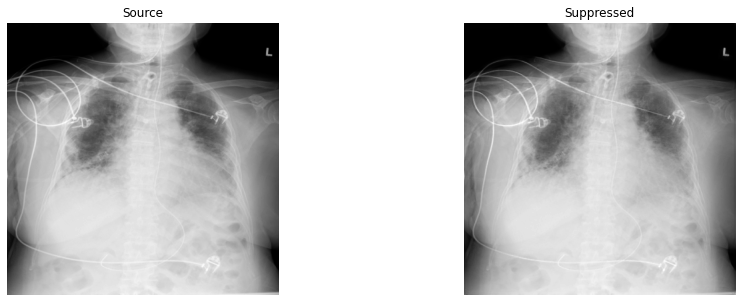

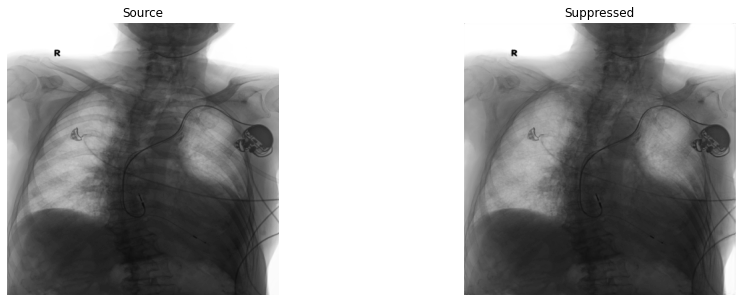

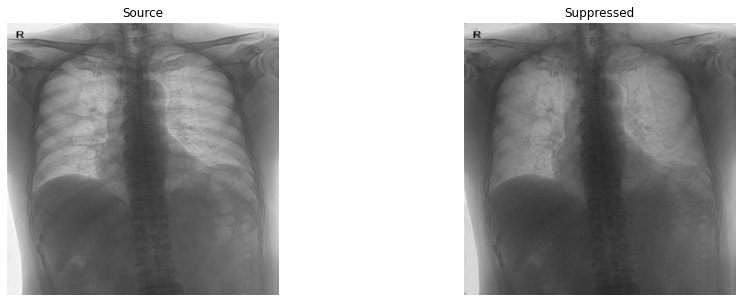

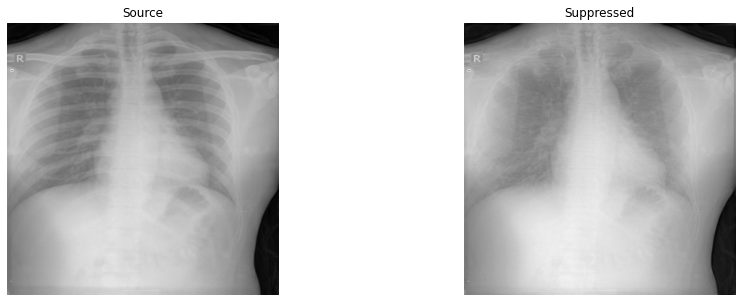

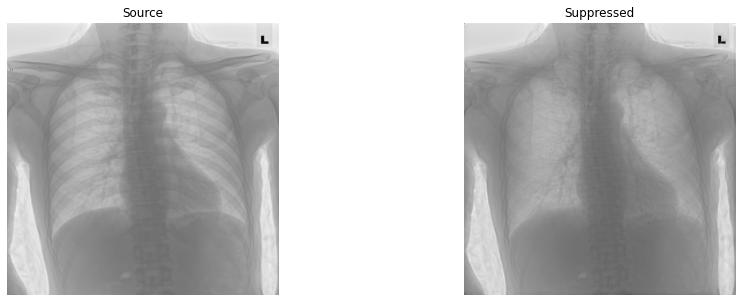

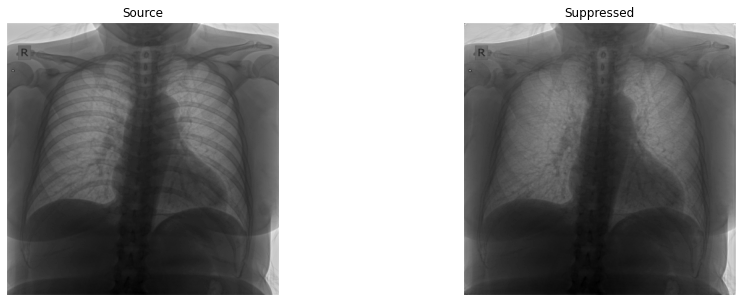

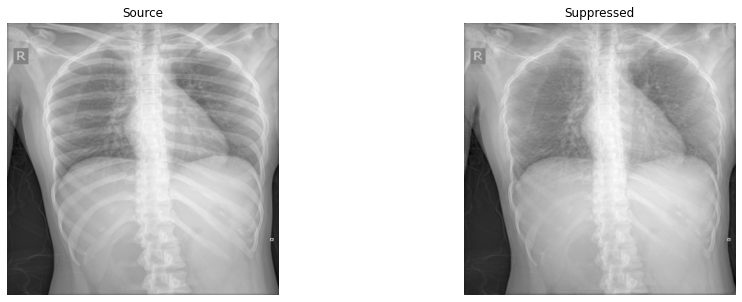

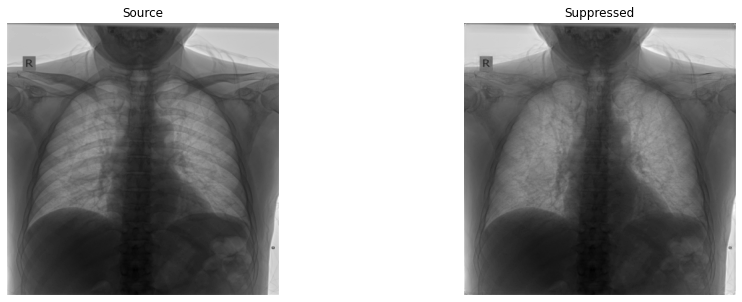

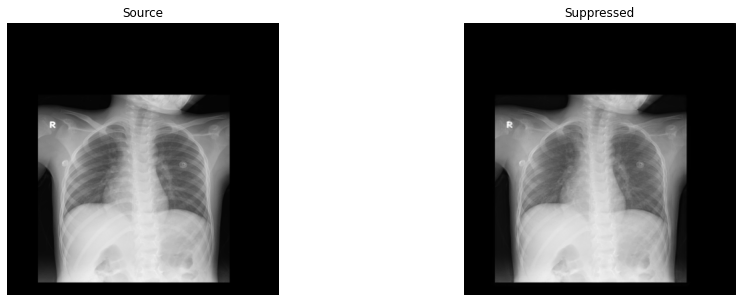

<Figure size 432x288 with 0 Axes>

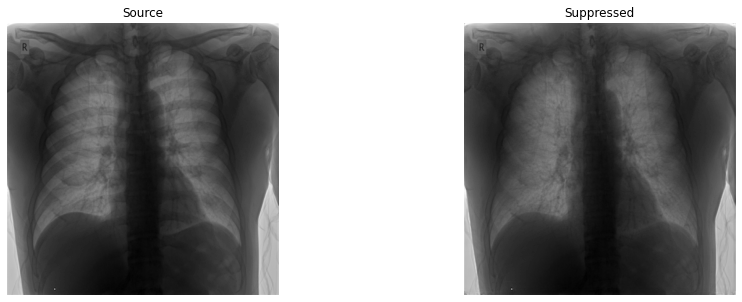

In [3]:
# Display
save_directory = os.path.split(PATH_SAVE_NETWORK_INTERMEDIATE)[0]
print(save_directory)
for batch_idx in range(_batch_size):
    if "boneless" in keys_images:
        plt.figure(1)
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        ax[0].imshow(sample["source"][batch_idx,0,:],cmap='gray')
        ax[0].set_title("Source")
        ax[0].axis("off")
        ax[1].imshow(out[batch_idx,0,:],cmap='gray')
        ax[1].set_title("Suppressed")
        ax[1].axis("off")
        ax[2].imshow(sample["boneless"][batch_idx,0,:],cmap='gray')
        ax[2].set_title("Ideal")
        ax[2].axis("off")
    else:
        plt.figure(1)
        fig, ax = plt.subplots(1,2, figsize=(15,5))
        ax[0].imshow(sample["source"][batch_idx,0,:],cmap='gray')
        ax[0].set_title("Source")
        ax[0].axis("off")
        ax[1].imshow(out[batch_idx,0,:],cmap='gray')
        ax[1].set_title("Suppressed")
        ax[1].axis("off")
    if flag_savePictures:
        plt.savefig(os.path.join(save_directory, switch + "_comparisonImages_"+ str(batch_idx) +".png"))

In [4]:
# Analysis
def PSNR(image, reference, max_reference=1.):
    """ 
    Peak Signal-to-Noise Ratio
    Input image and reference assumed to be Torch Tensors of shape [NxCxHxW]
    """
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    rtMSE = torch.sqrt(MSE)
    
    output = 20*torch.log10(max_reference/rtMSE)
    return output.numpy().squeeze()

def NPS():
    """Noise Power Spectrum"""
    

def SSIM(image, reference):
    iters = 0
    out_list = np.ndarray(image.size(0))
    for im in image:
        im = im.numpy()
        im = np.moveaxis(im, 0,-1)
        ref = reference[iters,:].numpy()
        ref = np.moveaxis(ref, 0,-1)
        out = skimage.metrics.structural_similarity(im, ref, multichannel=True)
        out_list[iters]=out
        iters+=1
    return out_list

def MSE(image, reference):
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    out_list = np.squeeze(MSE.numpy())
    return out_list

psnr_dict={"source_to_boneless":[], "suppressed_to_boneless":[]}
ssim_dict={"source_to_boneless":[], "suppressed_to_boneless":[]}
MSE_dict ={"source_to_boneless":[], "suppressed_to_boneless":[]}
if "boneless" in keys_images:
    for sample in dl:
        # Neural network
        out = net(sample["source"])
        out = out.detach()
        
        psnr_dict["source_to_boneless"].append(PSNR(sample["source"], sample["boneless"]))
        psnr_dict["suppressed_to_boneless"].append(PSNR(out, sample["boneless"]))
        ssim_dict["source_to_boneless"].append(SSIM(sample["source"], sample["boneless"]))
        ssim_dict["suppressed_to_boneless"].append(SSIM(out, sample["boneless"]))
        MSE_dict["source_to_boneless"].append(MSE(sample["source"], sample["boneless"]))
        MSE_dict["suppressed_to_boneless"].append(MSE(out, sample["boneless"]))
#print("PSNR original: {} ; after denoising: {} ".format(PSNR(sample["source"], sample["boneless"]).mean(), PSNR(out, sample["boneless"]).mean()))
#print("SSIM original: {} ; after denoising: {} ".format(SSIM(sample["source"], sample["boneless"]).mean(), SSIM(out, sample["boneless"]).mean()))
print(os.path.split(PATH_SAVE_NETWORK_INTERMEDIATE))

('.', 'trained_network.tar')


In [5]:
#print(psnr_dict)
print(str(np.concatenate(psnr_dict["source_to_boneless"]).mean()) + "," + str(np.concatenate(psnr_dict["suppressed_to_boneless"]).mean()))
print(str(np.concatenate(ssim_dict["source_to_boneless"]).mean()) + "," + str(np.concatenate(ssim_dict["suppressed_to_boneless"]).mean()))
print(str(np.mean(np.sqrt(np.concatenate(MSE_dict["source_to_boneless"])))) +","+ str(np.mean(np.sqrt(np.concatenate(MSE_dict["suppressed_to_boneless"])))))

ValueError: need at least one array to concatenate